Evaluating Regularized Xception model for FER task:

https://github.com/elangarka/Regularized-Xception-FER-Extra-Training-Data-Step-Decay-Learning-Rate

Eval Dataset:

https://osf.io/7a5fs/files/osfstorage


In [1]:
import numpy as np
import pandas as pd

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import SeparableConv2D as KerasSeparableConv2D

import os
import cv2
from tensorflow.keras.preprocessing import image
from sklearn.metrics import accuracy_score


In [2]:
class SeparableConv2DWrapper(KerasSeparableConv2D):
    def __init__(self, *args, **kwargs):
        # Remove unsupported keyword arguments
        kwargs.pop('groups', None)
        kwargs.pop('kernel_initializer', None)
        kwargs.pop('kernel_regularizer', None)
        kwargs.pop('kernel_constraint', None)
        super().__init__(*args, **kwargs)

In [3]:
# Load the model with custom_objects
emotion_model = load_model(
    '../checkpoints/bestXceptionPlusData.h5',
    custom_objects={'SeparableConv2D': SeparableConv2DWrapper}
)

In [4]:
dataset_path = '../datasets/Emotional_faces/'

emotions = ['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

In [5]:
# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

face_cascade = cv2.CascadeClassifier('../src/haarcascade_frontalface_default.xml')

# Loop through each folder (each folder represents an id)
for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        # Loop through each image in the folder
        for img_name in os.listdir(folder_path):
            img_path = os.path.join(folder_path, img_name)
            # Load the image
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

            faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)

            # If no faces are detected, skip this image
            if len(faces) == 0:
                print(f"No face detected in {img_path}, skipping")
                continue

            # extract the first face
            (x, y, w, h) = faces[0]
            face_roi = img[y:y + h, x:x + w]

            # Resize the face ROI to the required size
            try:
                resized_face = cv2.resize(face_roi, (48, 48), interpolation=cv2.INTER_AREA)
            except cv2.error as e:
                print(f"Error resizing face in {img_path}: {e}, skipping")
                continue

            # Expand dimensions and normalize
            img_array = np.expand_dims(resized_face, axis=0)
            img_array = np.expand_dims(img_array, axis=-1)  # Add channel dimension
            img_array = img_array.astype('float32') / 255.0

            prediction = emotion_model.predict(img_array)
            predicted_emotion = emotions[np.argmax(prediction)]

            true_labels.append(img_name.split('.')[0].lower())  # Assuming the image name is the true label
            predictions.append(predicted_emotion)

accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━

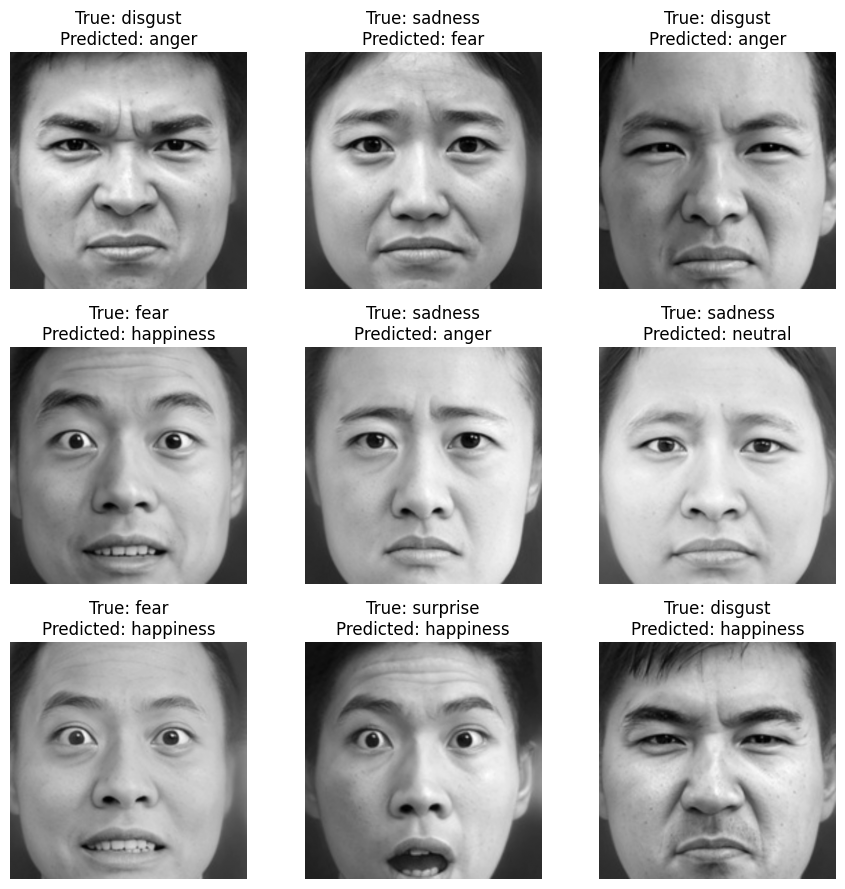

In [6]:
import random

import matplotlib.pyplot as plt

# Find indices where the predictions were incorrect
incorrect_indices = [i for i in range(len(true_labels)) if true_labels[i] != predictions[i]]

# Randomly sample up to 9 incorrect predictions
sample_size = min(9, len(incorrect_indices))
sampled_indices = random.sample(incorrect_indices, sample_size)

plt.figure(figsize=(9, 9))
folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

for i, index in enumerate(sampled_indices):
    img_found = False
    # Randomly shuffle folders to ensure we sample from different folders
    random.shuffle(folders)
    
    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        img_path = os.path.join(folder_path, f'{true_labels[index].capitalize()}.jpg')
        if os.path.exists(img_path):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)
                if len(faces) > 0:
                    x, y, w, h = faces[0]
                    face = img[y:y+h, x:x+w]
                    face = cv2.resize(face, (480, 480))
                    img_found = True
                    break
            except:
                continue
    
    if img_found:
        plt.subplot(3, 3, i + 1)
        plt.imshow(face, cmap='gray')
        plt.title(f"True: {true_labels[index]}\nPredicted: {predictions[index]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


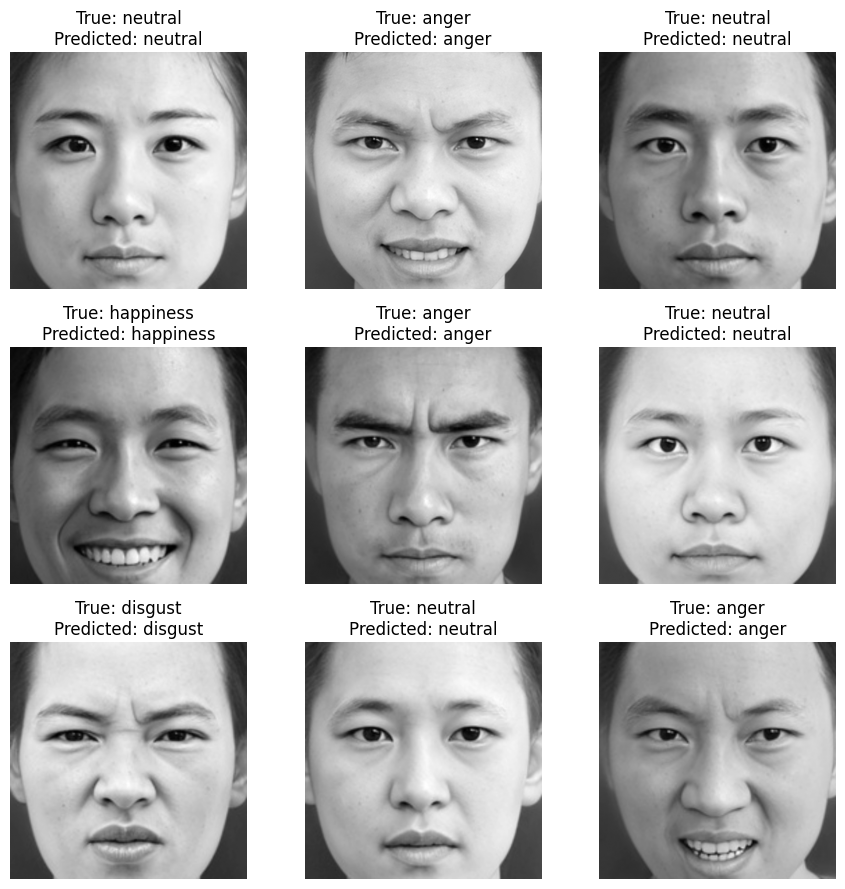

In [7]:
import random

import matplotlib.pyplot as plt

# Find indices where the predictions were incorrect
correct_indices = [i for i in range(len(true_labels)) if true_labels[i] == predictions[i]]

# Randomly sample up to 9 correct predictions
sample_size = min(9, len(correct_indices))
sampled_indices = random.sample(correct_indices, sample_size)

plt.figure(figsize=(9, 9))
folders = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]

for i, index in enumerate(sampled_indices):
    img_found = False
    # Randomly shuffle folders to ensure we sample from different folders
    random.shuffle(folders)
    
    for folder in folders:
        folder_path = os.path.join(dataset_path, folder)
        img_path = os.path.join(folder_path, f'{true_labels[index].capitalize()}.jpg')
        if os.path.exists(img_path):
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                faces = face_cascade.detectMultiScale(img, scaleFactor=1.1, minNeighbors=6)
                if len(faces) > 0:
                    x, y, w, h = faces[0]
                    face = img[y:y+h, x:x+w]
                    face = cv2.resize(face, (480, 480))
                    img_found = True
                    break
            except:
                continue
    
    if img_found:
        plt.subplot(3, 3, i + 1)
        plt.imshow(face, cmap='gray')
        plt.title(f"True: {true_labels[index]}\nPredicted: {predictions[index]}")
        plt.axis('off')

plt.tight_layout()
plt.show()


In [8]:
from sklearn.metrics import classification_report

print(classification_report(true_labels, predictions, target_names=emotions))

              precision    recall  f1-score   support

       anger       0.48      0.73      0.58       120
     disgust       0.79      0.26      0.39       120
        fear       0.55      0.43      0.48       120
   happiness       0.77      0.99      0.87       120
     sadness       0.46      0.97      0.63       120
    surprise       0.64      0.17      0.27       120
     neutral       0.75      0.53      0.62       120

    accuracy                           0.58       840
   macro avg       0.63      0.58      0.55       840
weighted avg       0.63      0.58      0.55       840

